# Tutorial on Bilevel Optimization
### with a deterministic example

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from BilevelProblem.BilevelProblem import BilevelProblem
from utils import plot_1D_iterations, plot_2D_functions, plot_loss

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

We set the dimensions and generate the data, in this toy example we have linear data where values $y \in R^{n\times 1}$ are generated by the function $h^*(w)=X\theta$ parametrized by the true coefficient vector $\theta\in R^{n\times 1}$ with the feature matrix $X\in R^{m\times n}$.

In [2]:
# Initialize dimesnions
n, m, m_v, m_t, batch = 2, 100000, 30000, 70000, 64
# The coefficient tensor of size (n,1) filled with values uniformally sampled from the range (0,1)
coef = np.random.uniform(size=(n,1)).astype('float32')
# The data tensor of size (m,n) filled with values uniformally sampled from the range (0,1)
X = np.random.uniform(size=(m, n)).astype('float32')
# True h_star
h_true = lambda X: X @ coef
y = h_true(X)
# Split X into 2 tensors with sizes [m_t, m_v] along dimension 0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)
# Convert everything to PyTorch tensors
X_train, X_val, y_train, y_val, coef = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(coef)
print("True coeficients:", coef)
print("X training data:", X_train[1:5])
print("y training labels:", y_train[1:5])
print()

dataset = [X_val,y_val,X_train,y_train]
maxiter = 1000
step = 0.1
mu_0_value = 3.
mu0 = torch.full((1,1), mu_0_value)

True coeficients: tensor([[0.5488],
        [0.7152]])
X training data: tensor([[0.5338, 0.5737],
        [0.7712, 0.1115],
        [0.3109, 0.5035],
        [0.0982, 0.0104]])
y training labels: tensor([[0.7033],
        [0.5030],
        [0.5307],
        [0.0613]])



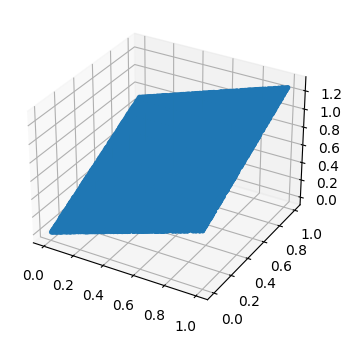

In [3]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.')
plt.show()

## Implicit Differentiation

Here we consider a linear toy example of a bilevel problem where $X_v$ is a $m_v\times n$ **validtaion set** feature matrix (every row is a feature vector of dimension $n$) and $y_v$ is an $m_v$ dimensional **validation set** true value vector (every member is the true value for a corresponding feature vector). Similarly, $X_t \in R^{m_t\times n}$ and $y \in R^{m_t}$ constitute the **training set**. We have the outer objective:
$$
  F(\mu, \theta^*) = \lVert X_v\theta^* - y_v \lVert^2
$$
and the inner objective:
$$
  s.t.\ \theta^*(x)\in \arg \min_{\theta} G(\mu, \theta) = \lVert X_t\theta - y_t \lVert^2 + \mu\lVert X_t\theta \lVert^2
$$
To use classical implicit differentiation we give a closed form solution of the lower objective $G(\mu, \theta)$ for a fixed $\mu$:

In [4]:
# A function to find optimal or closed form solution of h*
def find_theta_star(X, y, mu):
    """
    Find a closed form solution of theta for a fixed mu.
    """
    return torch.linalg.inv((1+2*mu) * X.T @ X) @ X.T @ y

We then provide all necessary gradients to compute the gradient $\nabla_\mu F$ as functions of the parameter vector $\theta$ and the outer parameter $\mu$:

In [5]:
# Objective functions
fo = lambda mu, theta, X_out, y_out: torch.mean((1/2)*torch.pow(((X_out @ theta) - y_out),2))
fi = lambda mu, theta, X_in, y_in: torch.mean((1/2)*torch.pow(((X_in @ theta) - y_in),2) + mu*torch.pow((X_in @ theta),2))

# Gradients
og1 = lambda mu, theta, X_out, y_out: torch.tensor([[0]])
og2 = lambda mu, theta, X_out, y_out: X_out.T @ (X_out @ theta - y_out)
ig22 = lambda mu, theta, X_in, y_in: X_in.T @ X_in + 2 * mu * X_in.T @ X_in
ig12 = lambda mu, theta, X_in, y_in: 2 * X_in.T @ X_in @ theta

Then we use **classical implicit differentiation** to find the optimal $\mu^*$:

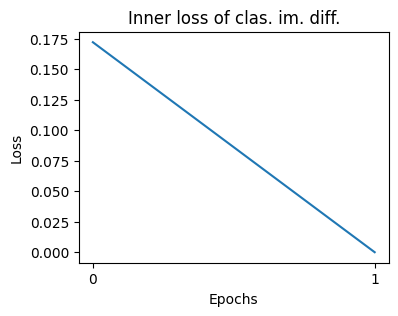

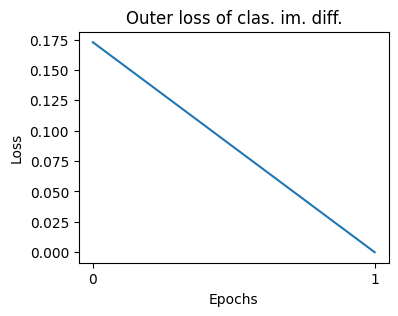

CLASSICAL IMPLICIT DIFFERENTIATION
Argmin of the outer objective: tensor([[8.0232e-06]])
Average iteration time: 0.0054285526275634766
Number of iterations: 2
True coefficients theta: tensor([[0.5488],
        [0.7152]])
Fitted coefficients theta: tensor([[0.5488],
        [0.7152]])


In [6]:
# Optimize using classical implicit differention
bp_classic = BilevelProblem(outer_objective=fo, inner_objective=fi, method="implicit_diff", data=dataset, gradients=[og1,og2,ig22,ig12], find_theta_star=find_theta_star)
mu_opt_c, iters_c, n_iters, times, inner_loss, outer_loss, theta = bp_classic.optimize(mu0, maxiter=maxiter, step=step)
plot_loss(inner_loss, title="Inner loss of clas. im. diff.")
plot_loss(outer_loss, title="Outer loss of clas. im. diff.")
h_star_c = lambda X: X @ theta

# Show results
print("CLASSICAL IMPLICIT DIFFERENTIATION")
print("Argmin of the outer objective:", mu_opt_c)
print("Average iteration time:", np.average(times))
print("Number of iterations:", n_iters)
print("True coefficients theta:", coef)
print("Fitted coefficients theta:", theta)

## Neural Implicit Differentiation

To use neural implicit differentiation we reformulate the problem into a **functional bilevel problem**:
$$
  F(\mu, h^*) = \lVert h^*(X_v) - y_v \lVert^2
$$
and the inner objective:
$$
  s.t.\ h^*(x)\in \arg \min_{h\in H} G(\mu, h) = \lVert h(X_t) - y_t \lVert^2 + \mu\lVert h(X_t) \lVert^2
$$

We provide all necessary gradients to compute the gradient $\nabla_\mu F$ as functions of the function $h$ and the outer parameter $\mu$:

In [7]:
# Objective functions
fo = lambda mu, h, X_out, y_out: torch.mean((1/2)*torch.pow((h(X_out) - y_out),2))
fi = lambda mu, h, X_in, y_in: torch.mean((1/2)*torch.pow((h(X_in) - y_in),2) + mu*torch.pow(h(X_in),2))

# Gradients
og1 = lambda mu, h, X_out, y_out: torch.tensor([[0]])
og2 = lambda mu, h, X_out, y_out: (h(X_out) - y_out)
ig22 = lambda mu, h, X_in, y_in: torch.eye(len(y_in)) * (1+2*mu)
ig12 = lambda mu, h, X_in, y_in: 2*h(X_in)

Then we use **neural implicit differentiation** to find the optimal $\mu^*$:

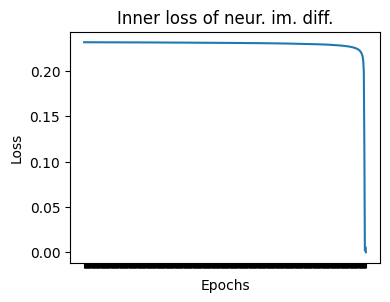

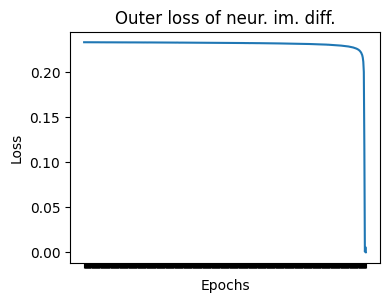

NEURAL IMPLICIT DIFFERENTIATION
Argmin of the outer objective: tensor([[0.]])
Average iteration time: 18.47570572497693
Number of iterations: 534



In [8]:
# Optimize using neural implicit differention
bp_neural = BilevelProblem(outer_objective=fo, inner_objective=fi, method="neural_implicit_diff", data=dataset, gradients=[og1,og2,ig22,ig12])
mu_opt_n, iters_n, n_iters, times, inner_loss, outer_loss, h_star_n = bp_neural.optimize(mu0, maxiter=maxiter, step=step)
plot_loss(inner_loss, title="Inner loss of neur. im. diff.")
plot_loss(outer_loss, title="Outer loss of neur. im. diff.")

# Show results
print("NEURAL IMPLICIT DIFFERENTIATION")
print("Argmin of the outer objective:", mu_opt_n)
print("Average iteration time:", np.average(times))
print("Number of iterations:", n_iters)
print()

## Camparison
We can compare classical and neural implicit differentiation by looking at the objective function that the model has inferred.

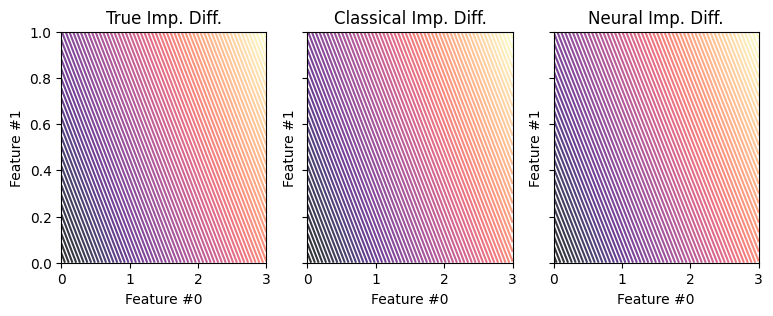

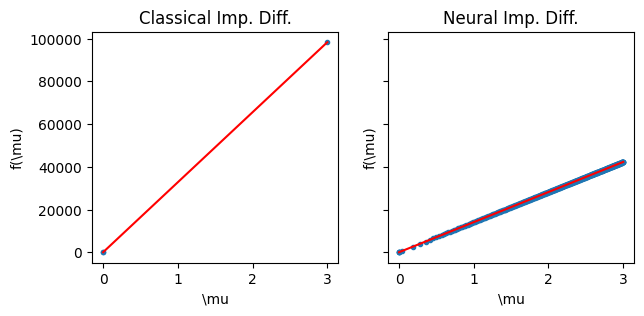

In [9]:
f_c = lambda mu : torch.pow(torch.norm((h_star_c(X_train) - y_train)),2) + (mu.clone().detach())*torch.pow(torch.norm(h_star_c(X_train)),2)
f_n = lambda mu : torch.pow(torch.norm((h_star_n(X_val) - y_val)),2) + mu*torch.pow(torch.norm(h_star_n(X_val)),2)
plot_2D_functions(h_true, h_star_c, h_star_n, points=None, plot_x_lim=[0,mu_0_value], plot_y_lim=[0,1], plot_nb_contours=80, titles=["True Imp. Diff.","Classical Imp. Diff.","Neural Imp. Diff."])
plot_1D_iterations(iters_c, iters_n, f_c, f_n, plot_x_lim=[0,mu_0_value], titles=["Classical Imp. Diff.","Neural Imp. Diff."])

Also by looking at the trajectory of the iterations and how fast $\mu$ approaches the minimum $0$ in both cases.

In [10]:
# Testing a*
X_test = torch.from_numpy(np.random.uniform(size=(100, n)).astype('float32'))
y_test = h_true(X_test)
h_theta_grad = lambda X : X
outer_grad2_h = lambda mu, h, X_out, y_out: (h(X_out) - y_out)
a_star_c = bp_classic.a_star(mu_opt_c, outer_grad2_h, h_star_c, h_theta_grad)
a_star_n = bp_neural.a_star
print(torch.norm(a_star_c(X_test, y_test) - a_star_n(X_test)))

tensor(0.0282, grad_fn=<NormBackward1>)
